# CrowdTruth for Sparse Multiple Choice Tasks: Event Extraction

In this tutorial, we will apply CrowdTruth metrics to a **sparse multiple choice** crowdsourcing task for **Event Extraction** from sentences. The workers were asked to read a sentence and then pick from a multiple choice list which are the words or words phrases in the sentence that are events or actions. The options available in the multiple choice list change with the input sentence. The task was executed on [FigureEight](https://www.figure-eight.com/). For more crowdsourcing annotation task examples, click [here](https://raw.githubusercontent.com/CrowdTruth-core/tutorial/getting_started.md).

In this tutorial, we will also show how to *translate an open task to a closed task* by processing *both the input units and the annotations* of a crowdsourcing task, and how this impacts the results of the CrowdTruth quality metrics. We start with an *open-ended extraction task*, where the crowd was asked to read a sentence and then pick from a multiple choice list which are the words or words phrases in the sentence that are events or actions.

To replicate this experiment, the code used to design and implement this crowdsourcing annotation template is available here: [template](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/Events-Text-Sparse-Multiple-Choice/template.html), [css](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/Events-Text-Sparse-Multiple-Choice/template.css), [javascript](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/Events-Text-Sparse-Multiple-Choice/template.js). 

This is a screenshot of the task as it appeared to workers:

![Task Template](../img/event-text-sparse-multiple-choice.png)

A sample dataset for this task is available in [this file](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/data/event-text-sparse-multiple-choice.csv), containing raw output from the crowd on FigureEight. Download the file and place it in a folder named `data` that has the same root as this notebook. Now you can check your data:

In [1]:
import pandas as pd
file_name = "all_platinum_crowd"
test_data = pd.read_csv("../crowd_data/" + file_name + ".csv")
test_data.head()

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,...,sentence,sentence_id,stanford_lemma,stanford_lower_lemma,stanford_pos_tag,tagged_events_gold,time_expressions,tokens,all_events,worker_events
0,2075970421,1/5/2019 22:20:20,4395945857,1/5/2019 22:20:05,False,instagc,1,22431902,GBR,G6,...,The ruling does not necessarily mean that Mr. ...,4,the ruling do not necessarily mean that Mr. Sa...,the ruling do not necessarily mean that mr. sa...,"DT NN VBZ RB RB VB IN NNP NNP , WP VBD PRP$ NN...",NaN,1,30,"[""ruling__4__10"",""lost__60__64"",""trial__162__1...","[""ruling__4__10"",""lost__60__64"",""trial__162__1..."
1,2075970421,1/5/2019 22:35:20,4395971287,1/5/2019 22:34:58,False,prodege,1,4316379,CAN,ON,...,The ruling does not necessarily mean that Mr. ...,4,the ruling do not necessarily mean that Mr. Sa...,the ruling do not necessarily mean that mr. sa...,"DT NN VBZ RB RB VB IN NNP NNP , WP VBD PRP$ NN...",NaN,1,30,"[""ruling__4__10"",""lost__60__64"",""re-election__...","[""ruling__4__10"",""lost__60__64"",""re-election__..."
2,2075970421,1/5/2019 22:35:28,4395971489,1/5/2019 22:35:13,False,instagc,1,21613169,GBR,I9,...,The ruling does not necessarily mean that Mr. ...,4,the ruling do not necessarily mean that Mr. Sa...,the ruling do not necessarily mean that mr. sa...,"DT NN VBZ RB RB VB IN NNP NNP , WP VBD PRP$ NN...",NaN,1,30,"[""ruling__4__10""]","[""ruling__4__10""]"
3,2075970421,1/5/2019 22:51:02,4395998416,1/5/2019 22:50:20,False,keeprewarding,1,44637936,CAN,NS,...,The ruling does not necessarily mean that Mr. ...,4,the ruling do not necessarily mean that Mr. Sa...,the ruling do not necessarily mean that mr. sa...,"DT NN VBZ RB RB VB IN NNP NNP , WP VBD PRP$ NN...",NaN,1,30,"[""ruling__4__10"",""lost__60__64"",""will__151__15...","[""ruling__4__10"",""lost__60__64"",""will__151__15..."
4,2075970421,1/5/2019 23:16:57,4396037471,1/5/2019 23:16:14,False,elite,1,32173500,GBR,E4,...,The ruling does not necessarily mean that Mr. ...,4,the ruling do not necessarily mean that Mr. Sa...,the ruling do not necessarily mean that mr. sa...,"DT NN VBZ RB RB VB IN NNP NNP , WP VBD PRP$ NN...",NaN,1,30,"[""ruling__4__10"",""lost__60__64"",""prosecution__...","[""ruling__4__10"",""lost__60__64"",""prosecution__..."


## Declaring a pre-processing configuration

The pre-processing configuration defines how to interpret the raw crowdsourcing input. To do this, we need to define a configuration class. First, we import the default CrowdTruth configuration class:

In [2]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig

Our test class inherits the default configuration `DefaultConfig`, while also declaring some additional attributes that are specific to the Relation Extraction task:

* **`inputColumns`:** list of input columns from the .csv file with the input data
* **`outputColumns`:** list of output columns from the .csv file with the answers from the workers
* **`annotation_separator`:** string that separates between the crowd annotations in `outputColumns`
* **`open_ended_task`:** boolean variable defining whether the task is open-ended (i.e. the possible crowd annotations are not known beforehand, like in the case of free text input); in the task that we are processing, workers pick the answers from a pre-defined list, therefore the task is not open ended, and this variable is set to `False`
* **`annotation_vector`:** list of possible crowd answers, mandatory to declare when `open_ended_task` is `False`; for our task, this is the list of all relations that were given as input to the crowd in at least one sentence
* **`processJudgments`:** method that defines processing of the raw crowd data; for this task, we process the crowd answers to correspond to the values in `annotation_vector`

The complete configuration class is declared below:

In [3]:
class TestConfig(DefaultConfig):
    inputColumns = ["doc_id", "total_events_gold", "sentence", "lowercase_sentence", "sentence_id", "all_possible_pgsm_events", "worker_events"]
    outputColumns = ["all_events"]
    
    annotation_separator = ","
        
    # processing of a closed task
    open_ended_task = True
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
            # remove square brackets from annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(']',''))
            # remove the quotes around the annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('"',''))
        return judgments

## Pre-processing the input data

After declaring the configuration of our input file, we are ready to pre-process the crowd data:

In [4]:
data_open, config = crowdtruth.load(
    file = "../crowd_data/" + file_name + ".csv",
    config = TestConfig()
)

data_open['judgments'].head()

,output.all_events,output.all_events.count,output.all_events.unique,submitted,started,worker,unit,duration,job
judgment,,,,,,,,,
4395945857,"{u'ruling__4__10': 1, u'lost__60__64': 1, u'tr...",3,3,2019-01-05 22:20:20,2019-01-05 22:20:05,22431902,2075970421,15,../crowd_data/all_platinum_crowd
4395971287,"{u'ruling__4__10': 1, u'lost__60__64': 1, u're...",3,3,2019-01-05 22:35:20,2019-01-05 22:34:58,4316379,2075970421,22,../crowd_data/all_platinum_crowd
4395971489,{u'ruling__4__10': 1},1,1,2019-01-05 22:35:28,2019-01-05 22:35:13,21613169,2075970421,15,../crowd_data/all_platinum_crowd
4395998416,"{u'ruling__4__10': 1, u'lost__60__64': 1, u'wi...",4,4,2019-01-05 22:51:02,2019-01-05 22:50:20,44637936,2075970421,42,../crowd_data/all_platinum_crowd
4396037471,"{u'ruling__4__10': 1, u'lost__60__64': 1, u'pr...",4,4,2019-01-05 23:16:57,2019-01-05 23:16:14,32173500,2075970421,43,../crowd_data/all_platinum_crowd


## Computing the CrowdTruth metrics

The pre-processed data can then be used to calculate the CrowdTruth metrics:

In [5]:
results_open = crowdtruth.run(data_open, config)

`results` is a dict object that contains the quality metrics for sentences, events and crowd workers.

The **sentence metrics** are stored in `results["units"]`:

In [6]:
results_open["units"].head()

,duration,input.all_possible_pgsm_events,input.doc_id,input.lowercase_sentence,input.sentence,input.sentence_id,input.worker_events,job,output.all_events,output.all_events.annotations,output.all_events.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,,,
2075970126,52.933333,"covering__82__90###Met__53__56###,__46__47###O...",bbc_20130322_1600,there are 12 flood warnings in the south west ...,There are 12 flood warnings in the South West ...,4,"[""covering__82__90"",""flood__13__18"",""warnings_...",../crowd_data/all_platinum_crowd,"{u'flood warnings__13__27': 1, u'in__28__30': ...",58,13,15,0.536270,"{u'flood warnings__13__27': 0.072939456288, u'...",0.506402,"{u'flood warnings__13__27': 0.0666666666667, u..."
2075970127,72.133333,expects__3__10###take__45__49###complete__78__...,bbc_20130322_332,bp expects the share buyback programme could t...,BP expects the share buyback programme could t...,6,"[""expects__3__10"",""take__45__49"",""complete__78...",../crowd_data/all_platinum_crowd,"{u'buyback programme__21__38': 1, u'share__15_...",48,10,15,0.709378,{u'buyback programme__21__38': 0.0449818463193...,0.618375,{u'buyback programme__21__38': 0.0666666666667...
2075970128,35.133333,helped__51__57###summit__103__109###was__25__2...,bbc_20130322_1150,new zealand-born mr lowe was part of the team ...,New Zealand-born Mr Lowe was part of the team ...,2,"[""helped__51__57""]",../crowd_data/all_platinum_crowd,"{u'summit__103__109': 9, u'was part of the tea...",34,6,15,0.673522,"{u'summit__103__109': 0.61666710994, u'was par...",0.647597,"{u'summit__103__109': 0.6, u'was part of the t..."
2075970129,27.600000,conquered__50__59###died__80__84###surviving__...,bbc_20130322_1150,the last surviving member of the team which fi...,The last surviving member of the team which fi...,0,"[""conquered__50__59"",""died__80__84""]",../crowd_data/all_platinum_crowd,"{u'everest__60__67': 4, u'in__68__70': 2, u'di...",57,11,15,0.685742,"{u'everest__60__67': 0.250453034802, u'in__68_...",0.673428,"{u'everest__60__67': 0.266666666667, u'in__68_..."
2075970130,41.466667,took__13__17###expedition__46__56###made__78__...,bbc_20130322_1150,mr lowe also took part in the trans-antarctic ...,Mr Lowe also took part in the trans-Antarctic ...,4,"[""expedition__46__56"",""made__78__82"",""crossing...",../crowd_data/all_platinum_crowd,"{u'took__13__17': 11, u'took part__13__22': 2,...",78,23,15,0.566477,"{u'took__13__17': 0.785857832367, u'took part_...",0.540694,"{u'took__13__17': 0.733333333333, u'took part_..."


The `uqs` column in `results["units"]` contains the **sentence quality scores**, capturing the overall workers agreement over each sentence. Here we plot its histogram:

Text(0,0.5,u'Sentences')

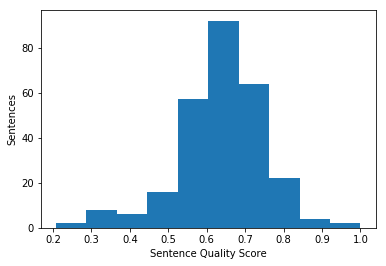

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(results_open["units"]["uqs"])
plt.xlabel("Sentence Quality Score")
plt.ylabel("Sentences")


The `unit_annotation_score` column in `results["units"]` contains the **sentence-relation scores**, capturing the likelihood that a relation is expressed in a sentence. For each sentence, we store a dictionary mapping each relation to its sentence-relation score.

In [8]:
results_open["units"]["unit_annotation_score"].head(10)

unit
2075970126    {u'flood warnings__13__27': 0.072939456288, u'...
2075970127    {u'buyback programme__21__38': 0.0449818463193...
2075970128    {u'summit__103__109': 0.61666710994, u'was par...
2075970129    {u'everest__60__67': 0.250453034802, u'in__68_...
2075970130    {u'took__13__17': 0.785857832367, u'took part_...
2075970131    {u'climbing__17__25': 0.709189490655, u'mike w...
2075970132    {u'said__38__42': 0.777424393245, u'on__135__1...
2075970133    {u'invested in__3__14': 0.0706485099775, u'in_...
2075970134    {u'formation__71__80': 0.814972272233, u'the f...
2075970135    {u'no_event': 0.0814938695331, u'said__3__7': ...
Name: unit_annotation_score, dtype: object

The **worker metrics** are stored in `results["workers"]`:

In [9]:
results_open["workers"].head()

,duration,job,judgment,unit,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial
worker,,,,,,,,,,
4316379,55.456693,1,127,127,0.473811,0.641101,0.739058,0.433827,0.603785,0.718512
6336109,80.428571,1,7,7,0.349609,0.554216,0.630817,0.283160,0.497375,0.569308
6340330,18.111111,1,36,36,0.501964,0.628326,0.798891,0.474794,0.597540,0.794581
6350548,352.500000,1,2,2,0.610244,0.728565,0.837596,0.586134,0.708234,0.827599
6432269,70.320000,1,100,100,0.504565,0.653497,0.772100,0.474741,0.624723,0.759922


The `wqs` columns in `results["workers"]` contains the **worker quality scores**, capturing the overall agreement between one worker and all the other workers.

Text(0,0.5,u'Workers')

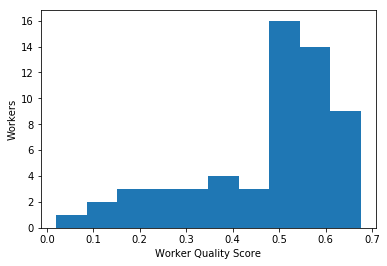

In [10]:
plt.hist(results_open["workers"]["wqs"])
plt.xlabel("Worker Quality Score")
plt.ylabel("Workers")

In [11]:
print(results_open["units"]["output.all_events"].iloc[0])

Counter({'warnings__19__27': 12, 'covering__82__90': 10, 'flood__13__18': 10, 'warnings__64__72': 7, 'snow__77__81': 6, 'are__6__9': 3, 'in__28__30': 2, 'met__53__56': 2, 'for__73__76': 2, 'flood warnings__13__27': 1, 'there__0__5': 1, '12 flood warnings__10__27': 1, 'office__57__63': 1})


## Save crowd results in a csv file

In [13]:
import collections
from collections import Counter

rows = []
header = list(results_open["units"])
header.extend(["validated_event", "no_of_annotations", "validated_event_final_score", "validated_event_initial_score"])

rows.append(header)

for i in range(len(results_open["units"].index)):
    keys = []
    all_event_runs = results_open["units"]["input.all_possible_pgsm_events"].iloc[i].lower().split("###")
    keys.extend(all_event_runs)
    keys.append("no_event")
    
    for crowd_event in results_open["units"]["output.all_events"].iloc[i]:
        crowd_event = crowd_event.replace("###", ",")
        crowd_event = crowd_event.replace("---", "''")
        crowd_event = crowd_event.replace("|||", "'")
        if crowd_event not in keys:
            keys.append(crowd_event)
    
    for j in range(len(keys)):
        row = list(results_open["units"].iloc[i])
        row.append(keys[j])
        row.append(results_open["units"]["output.all_events"].iloc[i][keys[j].lower()])
        row.append(results_open["units"]["unit_annotation_score"].iloc[i][keys[j].lower()])
        row.append(results_open["units"]["unit_annotation_score_initial"].iloc[i][keys[j].lower()])
    
        rows.append(row)
        
        
import csv

with open('../crowd_data/' + file_name + '_units_open.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows)

## Comparison with Expert Annotations

In [14]:
# expert annotations in TempEval-3 Platinum dataset
import numpy as np
           
expert_data = pd.read_csv("../TempEval3-data/TE3-Platinum_events.csv")
crowd_data = pd.read_csv("../crowd_data/" + file_name + "_units_open.csv")
crowd_data["Experts"] = pd.Series(np.random.randn(len(crowd_data.index)), index=crowd_data.index)

for i in range(len(crowd_data.index)):
    subset = expert_data[(expert_data["Doc Id"].str.lower() == crowd_data["input.doc_id"].iloc[i].lower()) & (expert_data["Sentence Id"] == crowd_data["input.sentence_id"].iloc[i])]# & (str(str(expert_data["Lowercase Token"]) + "__" + str(expert_data["Start Offset"]) + "__" + str(expert_data["End Offset"])) == str(crowd_data["validated_event"].iloc[i]))]
    found = False
    for j in range(len(subset.index)):
        if str(str(subset["Lowercase Token"].iloc[j]) + "__" + str(subset["Start Offset"].iloc[j]) + "__" + str(subset["End Offset"].iloc[j])) == crowd_data["validated_event"].iloc[i]:
            found = True
    if found == True:
        crowd_data["Experts"].iloc[i] = 1
    else:
        crowd_data["Experts"].iloc[i] = 0
crowd_data.to_csv("../crowd_data/" + file_name + "_units_open.csv", index=False)    


/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
crowd_data = pd.read_csv("../crowd_data/" + file_name + "_units_open.csv")
expert_data = pd.read_csv("../TempEval3-data/TE3-Platinum_events.csv")

for i in range(len(crowd_data.index)):
    if crowd_data["validated_event"].iloc[i] == "no_event":
        subset = expert_data[(expert_data["Doc Id"].str.lower() == crowd_data["input.doc_id"].iloc[i].lower()) & (expert_data["Sentence Id"] == crowd_data["input.sentence_id"].iloc[i])]
        if len(subset.index) == 0:
            crowd_data["Experts"].iloc[i] = 1
crowd_data.to_csv("../crowd_data/" + file_name + "_units_open.csv", index=False) 

In [23]:
import eval_crowd_results as eval_script

crowd = pd.read_csv('../crowd_data/' + file_name + '_units_open.csv')
eval_file = eval_script.compute_crowd_performance(crowd, "validated_event_final_score")
     
with open('../crowd_data/eval_' + file_name + '_units_open.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(eval_file)
    
eval_main = pd.read_csv("../crowd_data/eval_" + file_name + "_units_open.csv")
eval_main

,Thresh,TP,TN,FP,FN,Precision,Recall,Accuracy,F1-score
0,0.05,757,311,1958,19,0.278821,0.975515,0.350739,0.433687
1,0.10,752,909,1360,24,0.356061,0.969072,0.545484,0.520776
2,0.15,746,1128,1141,30,0.395337,0.961340,0.615435,0.560270
3,0.20,742,1226,1043,34,0.415686,0.956186,0.646305,0.579461
4,0.25,738,1457,812,38,0.476129,0.951031,0.720854,0.634566
5,0.30,733,1603,666,43,0.523946,0.944588,0.767159,0.674023
6,0.35,728,1708,561,48,0.564779,0.938144,0.800000,0.705085
7,0.40,717,1814,455,59,0.611775,0.923969,0.831199,0.736140
8,0.45,702,1908,361,74,0.660395,0.904639,0.857143,0.763458
9,0.50,685,1981,288,91,0.704008,0.882732,0.875534,0.783305


In [24]:
import eval_crowd_results as eval_script

crowd_no_event = pd.read_csv('../crowd_data/' + file_name + '_units_open.csv')
crowd = crowd_no_event[crowd_no_event["validated_event"] != "no_event"]
eval_file = eval_script.compute_crowd_performance(crowd, "validated_event_final_score")
     
with open('../crowd_data/eval_' + file_name + '_units_open.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(eval_file)
    
eval_main = pd.read_csv("../crowd_data/eval_" + file_name + "_units_open.csv")
eval_main

,Thresh,TP,TN,FP,FN,Precision,Recall,Accuracy,F1-score
0,0.05,746,86,1940,0,0.277736,1.000000,0.300144,0.434732
1,0.10,742,672,1354,4,0.354008,0.994638,0.510101,0.522167
2,0.15,740,888,1138,6,0.394036,0.991957,0.587302,0.564024
3,0.20,736,985,1041,10,0.414181,0.986595,0.620851,0.583432
4,0.25,733,1215,811,13,0.474741,0.982574,0.702742,0.640175
5,0.30,730,1361,665,16,0.523297,0.978552,0.754329,0.681924
6,0.35,725,1465,561,21,0.563764,0.971850,0.790043,0.713583
7,0.40,714,1571,455,32,0.610778,0.957105,0.824315,0.745692
8,0.45,700,1665,361,46,0.659755,0.938338,0.853175,0.774765
9,0.50,683,1738,288,63,0.703399,0.915550,0.873377,0.795574


## Open to Closed Task Transformation

The goal of this crowdsourcing task is to understand how clearly a word or a word phrase is expressing an event or an action across all the sentences in the dataset and not at the level of a single sentence as previously. Therefore, in the remainder of this tutorial we show how to *translate an open task to a closed task* by processing *both the input units and the annotations* of a crowdsourcing task.

The answers from the crowd are stored in the `selected_events` column.

In [43]:
test_data["selectedtags_desc"][0:30]

0     ["informed__37__45","face__69__73","investigat...
1               ["informed__37__45","abused__113__119"]
2     ["investigation__83__96","campaign__266__274",...
3        ["investigation__83__96","campaign__266__274"]
4     ["investigation__83__96","campaign__266__274",...
5     ["informed__37__45","investigation__83__96","a...
6     ["investigation__83__96","campaign__266__274",...
7     ["informed__37__45","face__69__73","investigat...
8     ["informed__37__45","face__69__73","investigat...
9     ["informed__37__45","face__69__73","investigat...
10    ["investigation__83__96","abused__113__119","g...
11    ["informed__37__45","investigation__83__96","a...
12    ["abused__113__119","was__33__36","funds__234_...
13    ["informed__37__45","face__69__73","investigat...
14    ["informed__37__45","investigation__83__96","a...
15    ["informed__37__45","investigation__83__96","a...
16    ["informed__37__45","investigation__83__96","a...
17    ["informed__37__45","face__69__73","invest

As you already know, each word can be expressed in a canonical form, i.e., as a lemma. For example, the words: *run*, *runs*, *running*, they all have the lemma *run*. As you can see in the previous cell, events in text can appear under multiple forms. To evaluate the clarity of each event, we will process both the input units and the crowd annotations to refer to a word in its canonical form, i.e., we will lemmatize them. 

Following, we define the function used to lemmatize the options that are shown to the workers in the crowdsourcing task:

In [44]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_events(event):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(str(event.lower().split("__")[0])))  
    wn_tagged = map(lambda x: (str(x[0]), nltk2wn_tag(x[1])), nltk_tagged)
    res_words = []
                
    for word, tag in wn_tagged:
        if tag is None:            
            res_word = wordnet._morphy(str(word), wordnet.NOUN)
            if res_word == []:
                res_words.append(str(word))
            else:
                if len(res_word) == 1:
                    res_words.append(str(res_word[0]))
                else:
                    res_words.append(str(res_word[1]))
        else:
            res_word = wordnet._morphy(str(word), tag)
            if res_word == []:
                res_words.append(str(word))
            else: 
                if len(res_word) == 1:
                    res_words.append(str(res_word[0]))
                else:
                    res_words.append(str(res_word[1]))
    
    lematized_keyword = " ".join(res_words)
    return lematized_keyword

[nltk_data] Downloading package punkt to /Users/oanainel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/oanainel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oanainel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [45]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

[nltk_data] Downloading package punkt to /Users/oanainel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/oanainel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oanainel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The following functions create the values of the annotation vector and extracts the lemma of the events selected by each worker.

In [46]:
def define_annotation_vector(eventsList):  
    events = []
    for i in range(len(eventsList)):
        currentEvents = eventsList[i].split("###")
        
        for j in range(len(currentEvents)):
            if currentEvents[j] != "no_event":
                lematized_keyword = lemmatize_events(currentEvents[j])
                
                if lematized_keyword not in events:
                    events.append(lematized_keyword)
    events.append("no_event")   
    return events

def lemmatize_keywords(keywords, separator):
    keywords_list = keywords.split(separator)
    lematized_keywords = []
    
    for keyword in keywords_list:
        lematized_keyword = lemmatize_events(keyword)
        lematized_keywords.append(lematized_keyword)
    
    return separator.join(lematized_keywords)

In [47]:
class TestConfig(DefaultConfig):
    inputColumns = ["doc_id", "total_events_gold", "sentence", "lowercase_sentence", "sentence_id", "all_possible_pgsm_events"]
    outputColumns = ["selectedtags_desc"]
    
    annotation_separator = ","
        
    # processing of a closed task
    open_ended_task = False
    annotation_vector = define_annotation_vector(test_data["all_possible_pgsm_events"])
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
            # remove square brackets from annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace("[",""))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace("]",""))
            # remove the quotes around the annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('"',''))
            judgments[col] = judgments[col].apply(lambda x: lemmatize_keywords(str(x), self.annotation_separator))
        return judgments

In [48]:
data_closed, config = crowdtruth.load(
    file = "../pilot_data/" + file_name + ".csv",
    config = TestConfig()
)

data_closed['judgments'].head()

,output.selectedtags_desc,output.selectedtags_desc.count,output.selectedtags_desc.unique,submitted,started,worker,unit,duration,job
judgment,,,,,,,,,
4342347233,"{u'inform': 1, u'face': 1, u'investigation': 1...",9,209,2018-12-15 22:09:38,2018-12-15 22:08:40,6576528,2052545009,58,../pilot_data/f1330064_allpossibleevents_motiv...
4342347568,"{u'inform': 1, u'abuse': 1, u'face': 0, u'inve...",2,209,2018-12-15 22:09:50,2018-12-15 22:09:15,39147083,2052545009,35,../pilot_data/f1330064_allpossibleevents_motiv...
4342434462,"{u'investigation': 1, u'campaign': 1, u'be': 1...",3,209,2018-12-15 23:14:15,2018-12-15 23:13:49,44369755,2052545009,26,../pilot_data/f1330064_allpossibleevents_motiv...
4342502967,"{u'investigation': 1, u'campaign': 1, u'inform...",2,209,2018-12-16 00:10:14,2018-12-16 00:09:43,44369730,2052545009,31,../pilot_data/f1330064_allpossibleevents_motiv...
4342526569,"{u'investigation': 1, u'campaign': 1, u'fund':...",3,209,2018-12-16 00:30:48,2018-12-16 00:29:56,43912578,2052545009,52,../pilot_data/f1330064_allpossibleevents_motiv...


In [49]:
results_closed = crowdtruth.run(data_closed, config)

In [50]:
results_closed["annotations"]

,output.selectedtags_desc,aqs,aqs_initial
-,1000,1.000000e-08,1.000000e-08
`s,1000,2.293936e-01,1.911765e-01
ability,1000,3.954921e-01,3.684211e-01
abuse,1000,8.577486e-01,8.055556e-01
accept,1000,6.913489e-01,7.368421e-01
accepted,1000,9.591364e-01,9.473684e-01
accessible,1000,4.931666e-01,4.210526e-01
accuse,1000,7.093783e-01,6.315789e-01
add,1000,7.271006e-01,6.625000e-01
admit,1000,1.000000e+00,1.000000e+00


## Comparison with expert annotations

In [51]:
rows = []
header = list(results_closed["units"])
header.extend(["validated_event", "no_of_annotations", "validated_event_final_score", "validated_event_initial_score"])

rows.append(header)

for i in range(len(results_closed["units"].index)):
    keys = []
    all_event_runs = results_closed["units"]["input.all_possible_pgsm_events"].iloc[i].lower().split("###")
    
    for event in all_event_runs:
        evComp = event.split("__")
        #print(evComp[0])
        keys.append(lemmatize_keywords(str(evComp[0]), " "))
    keys.append("no_event")
    #print(keys)
    for j in keys:

        row = list(results_closed["units"].iloc[i])
        row.append(j)
        
        row.append(results_closed["units"]["output.selectedtags_desc"].iloc[i][j.lower()])
        row.append(results_closed["units"]["unit_annotation_score"].iloc[i][j.lower()])
        row.append(results_closed["units"]["unit_annotation_score_initial"].iloc[i][j.lower()])
        rows.append(row)
        
import csv

with open('../pilot_data/' + file_name + '_units_closed.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows)

In [52]:
# expert annotations in TempEval-3 Platinum dataset
import numpy as np
           
expert_data = pd.read_csv("../TempEval3-data/TE3-Platinum_events.csv")
crowd_data = pd.read_csv("../pilot_data/" + file_name + "_units_closed.csv")
crowd_data["Experts"] = pd.Series(np.random.randn(len(crowd_data.index)), index=crowd_data.index)

for i in range(len(crowd_data.index)):
    subset = expert_data[(expert_data["Doc Id"].str.lower() == crowd_data["input.doc_id"].iloc[i].lower()) & (expert_data["Sentence Id"] == crowd_data["input.sentence_id"].iloc[i])]# & (str(str(expert_data["Lowercase Token"]) + "__" + str(expert_data["Start Offset"]) + "__" + str(expert_data["End Offset"])) == str(crowd_data["validated_event"].iloc[i]))]
    found = False
    for j in range(len(subset.index)):
        if str(subset["Lowercase Lemma Stanford"].iloc[j]) == crowd_data["validated_event"].iloc[i]:
            found = True
    if found == True:
        crowd_data["Experts"].iloc[i] = 1
    else:
        crowd_data["Experts"].iloc[i] = 0
crowd_data.to_csv("../pilot_data/" + file_name + "_units_closed.csv", index=False)    

In [53]:
import eval_crowd_results as eval_script

crowd = pd.read_csv('../pilot_data/' + file_name + '_units_closed.csv')
eval_file = eval_script.compute_crowd_performance(crowd, "validated_event_final_score")
     
with open('../pilot_data/eval_' + file_name + '_units_closed.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(eval_file)
    
eval_main = pd.read_csv("../pilot_data/eval_" + file_name + "_units_closed.csv")
eval_main

,Thresh,TP,TN,FP,FN,Precision,Recall,Accuracy,F1-score
0,0.05,152,49,256,0,0.372549,1.000000,0.439825,0.542857
1,0.10,152,51,254,0,0.374384,1.000000,0.444201,0.544803
2,0.15,152,68,237,0,0.390746,1.000000,0.481400,0.561922
3,0.20,152,85,220,0,0.408602,1.000000,0.518600,0.580153
4,0.25,152,101,204,0,0.426966,1.000000,0.553611,0.598425
5,0.30,152,123,182,0,0.455090,1.000000,0.601751,0.625514
6,0.35,150,152,153,2,0.495050,0.986842,0.660832,0.659341
7,0.40,148,178,127,4,0.538182,0.973684,0.713348,0.693208
8,0.45,144,200,105,8,0.578313,0.947368,0.752735,0.718204
9,0.50,142,217,88,10,0.617391,0.934211,0.785558,0.743455


## Effect on CrowdTruth metrics

Finally, we can compare the effect of the transformation from an open task to a closed task on the CrowdTruth *sentence quality score*.

Text(0,0.5,u'closed task')

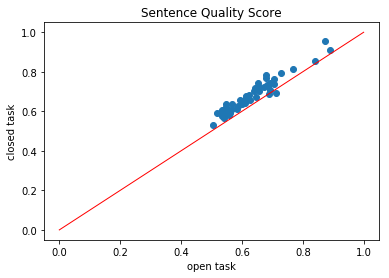

In [54]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.scatter(
    results_open["units"]["uqs"],
    results_closed["units"]["uqs"],
)
plt.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.title("Sentence Quality Score")
plt.xlabel("open task")
plt.ylabel("closed task")

Text(0,0.5,u'closed task')

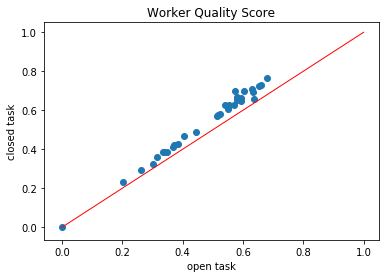

In [55]:
plt.scatter(
    results_open["workers"]["wqs"],
    results_closed["workers"]["wqs"],
)
plt.plot([0, 1], [0, 1], 'red', linewidth=1)
plt.title("Worker Quality Score")
plt.xlabel("open task")
plt.ylabel("closed task")

# Run replication experiments

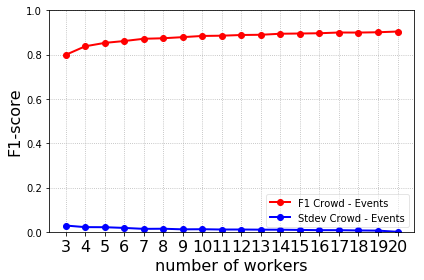

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

F1_3w = pd.read_csv("../scripts/F1_events_3.csv")
F1_4w = pd.read_csv("../scripts/F1_events_4.csv")
F1_5w = pd.read_csv("../scripts/F1_events_5.csv")
F1_6w = pd.read_csv("../scripts/F1_events_6.csv")
F1_7w = pd.read_csv("../scripts/F1_events_7.csv")
F1_8w = pd.read_csv("../scripts/F1_events_8.csv")
F1_9w = pd.read_csv("../scripts/F1_events_9.csv")
F1_10w = pd.read_csv("../scripts/F1_events_10.csv")
F1_11w = pd.read_csv("../scripts/F1_events_11.csv")
F1_12w = pd.read_csv("../scripts/F1_events_12.csv")
F1_13w = pd.read_csv("../scripts/F1_events_13.csv")
F1_14w = pd.read_csv("../scripts/F1_events_14.csv")
F1_15w = pd.read_csv("../scripts/F1_events_15.csv")
F1_16w = pd.read_csv("../scripts/F1_events_16.csv")
F1_17w = pd.read_csv("../scripts/F1_events_17.csv")
F1_18w = pd.read_csv("../scripts/F1_events_18.csv")
F1_19w = pd.read_csv("../scripts/F1_events_19.csv")
F1_20w = 0.904494


F1 = [F1_3w["f1"].mean(), F1_4w["f1"].mean(), F1_5w["f1"].mean(), F1_6w["f1"].mean(), F1_7w["f1"].mean(), 
      F1_8w["f1"].mean(), F1_9w["f1"].mean(), F1_10w["f1"].mean(), F1_11w["f1"].mean(), F1_12w["f1"].mean(), 
      F1_13w["f1"].mean(), F1_14w["f1"].mean(), F1_15w["f1"].mean(), F1_16w["f1"].mean(), F1_17w["f1"].mean(), 
      F1_18w["f1"].mean(), F1_19w["f1"].mean(), F1_20w]

std = [np.std(F1_3w["f1"]), np.std(F1_4w["f1"]), np.std(F1_5w["f1"]), np.std(F1_6w["f1"]), np.std(F1_7w["f1"]), 
      np.std(F1_8w["f1"]), np.std(F1_9w["f1"]), np.std(F1_10w["f1"]), np.std(F1_11w["f1"]), np.std(F1_12w["f1"]), 
      np.std(F1_13w["f1"]), np.std(F1_14w["f1"]), np.std(F1_15w["f1"]), np.std(F1_16w["f1"]), np.std(F1_17w["f1"]), 
      np.std(F1_18w["f1"]), np.std(F1_19w["f1"]), 0.0]

plt.rcParams['figure.figsize'] = 6, 4
plt.plot([x for x in range(3, 21)], F1, 'bo-',
         color = 'r', lw = 2, label = "F1 Crowd - Events")

plt.plot([x for x in range(3, 21)], std, 'bo-',
         color = 'blue', lw = 2, label = "Stdev Crowd - Events")

plt.xlabel("number of workers", fontsize=16)
plt.ylabel("F1-score", fontsize=16)
plt.xticks( range(3,21) , fontsize=16)
plt.ylim(0.0, 1.0)
leg = plt.legend(fontsize=10)
leg.get_frame().set_alpha(0.5)
plt.grid(ls=':')
plt.tight_layout()
plt.savefig("../pilot_data/events_no_of_workers.eps", format='eps', dpi=1000)
plt.show()
plt.close()

In [57]:
F1

[0.7991672941733231,
 0.837857883737571,
 0.8532049350599453,
 0.8616675649536606,
 0.8718640495844839,
 0.8741555309575467,
 0.8792469025174112,
 0.8845998997112902,
 0.8857574566989002,
 0.888863739903378,
 0.8899177195851684,
 0.8945797321339559,
 0.8955914440102007,
 0.8968321368773833,
 0.9001531522387047,
 0.8998524424485638,
 0.9013138391290092,
 0.904494]